Importing Dependencies

In [1]:
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
import cv2
import easyocr
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


Loading the saved yolo model

In [2]:
# Path to your trained weights
yolo_weights_path = r"C:\Users\acz\Desktop\SoulPage\trained_yolo_model\best.pt"

# Load the model with the trained weights
model_yolo = YOLO(yolo_weights_path)


Loading TrOCR Model and processor

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Load the model and processor
output_dir = r"best_model_e3"
model_1 = VisionEncoderDecoderModel.from_pretrained(output_dir)
processor_1 = TrOCRProcessor.from_pretrained(output_dir)

# Set the device to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\acz\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get the detected object locations and plot the image with bounding boxes

Loading the image

In [19]:
# Path to the image
original_image_path = r"C:\Users\acz\Desktop\imag\train\weights\test\901.jpg"

# Run inference on the image
results = model_yolo(original_image_path)


image 1/1 C:\Users\acz\Desktop\imag\train\weights\test\901.jpg: 640x480 1 number_plate, 272.0ms
Speed: 9.0ms preprocess, 272.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Getting the coordinates of detected object box in loaded image

ymin: 322.9709167480469, xmin: 122.04873657226562, ymax: 342.0570068359375, xmax: 197.69253540039062


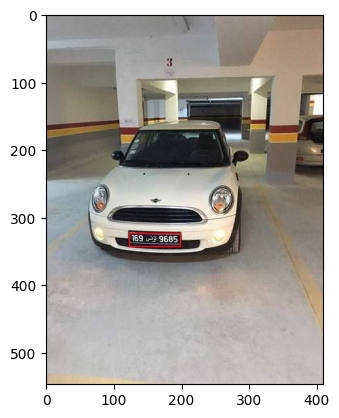

In [20]:
# Load the image
img = Image.open(original_image_path)

max_index = np.argmax(results[0].boxes.conf)

# Get the bounding box coordinates

xmin, ymin, xmax, ymax = results[0].boxes.xyxy[max_index.item()]
    
    # Print the coordinates in the required format
print(f"ymin: {ymin.item()}, xmin: {xmin.item()}, ymax: {ymax.item()}, xmax: {xmax.item()}")
    
# Draw the bounding box
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                    fill=False, edgecolor='red', linewidth=1))

        # Add text above the bounding box


# Show the image with bounding boxes
plt.imshow(img)
plt.show()

y_min, x_min, y_max, x_max = int(ymin.item()), int(xmin.item()), int(ymax.item()), int(xmax.item())

Cropping the Image to extract plate

Saving cropped image

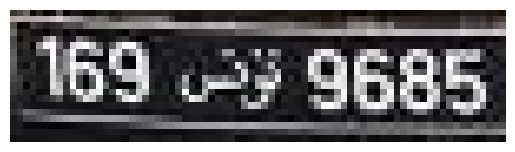

True

In [21]:
# Load the image
image = cv2.imread(original_image_path)

# Define the coordinates of the number plate [y_min, x_min, y_max, x_max]
coordinates = [y_min, x_min, y_max, x_max]

# Crop the image using the coordinates
cropped_image = image[coordinates[0]:coordinates[2], coordinates[1]:coordinates[3]]

# Display the cropped image (optional)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Save the cropped image (optional)
cv2.imwrite(r'Cropped_image\cropped_image.jpg', cropped_image)

## Loading the TrOCR model for text reading from number plate

Functions to preprocess the image before text recognition

In [22]:
from torchvision import transforms

# Custom transform
transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_and_pad(img, target_size=384)),
    transforms.ToTensor(),
])


def resize_and_pad(img, target_size=384):
    # Calculate scaling factor
    scale = min(target_size / img.size[0], target_size / img.size[1])
    
    # Resize image
    new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
    img_resized = img.resize(new_size, Image.LANCZOS)
    
    # Create new image with white background
    new_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    
    # Paste resized image onto center of new image
    new_img.paste(img_resized, ((target_size - new_size[0]) // 2,
                                (target_size - new_size[1]) // 2))
    
    return new_img


# Function to predict text from an image
def predict_text(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Generate the output text
    generated_ids = model_1.generate(pixel_values=image, max_length=16)
    generated_text = processor_1.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return generated_text



In [24]:
# Example usage
image_path = r"Cropped_image\cropped_image901.jpg"

predicted_text = predict_text(image_path)
print(f"Predicted License Plate Text: {predicted_text}")

Predicted License Plate Text: 169T9685


Model is able to detect the license plate and read the text

End 